# Carbonate-rich lakes modelling on the early Earth

<p class="acknowledgement">Written by Svetlana Kyas (ETH Zurich) on Feb 2th, 2022</p>

## Solubility of phosphate in the hydroxyl-, fluorapatite- and calcite-rich lakes

Reaktoro can be used for different geobiological simulations. One of the possible applications is the modelling
of carbonate-rich lakes, which were relatively common on early Earth.

```{note}
This tutorial is one of two tutorials that follow
the paper `Toner2020` and tries to replicate the geobiological simulations carried out in it.
The second tutorial is available through the link:
[**Phosphate accumulation in carbonate-rich brines**](geobiology-phreeqc-fixed-fugacity.ipynb)
This work was carried out together with Cara Magnabosco and Laura Murzakhmetov, ETH-Zurich.
```

Carbonate-rich lakes can be explained by the strong chemical weathering of abundant, fresh volcanic rocks under early
Earth’s CO<sub>2</sub>-rich atmosphere. Weathering would release phosphate from apatites (group of phosphate minerals)
and carbonate alkalinity from other minerals, which would accumulate in closed basins.

In Reaktoro, the Earth’s CO<sub>2</sub>-rich atmosphere can be modelled by fixing the fugacity of the modelled chemical states.
In particular, a consequence of early Earth’s CO<sub>2</sub>-rich atmosphere (corresponding to the partial pressure of CO<sub>2</sub> from -2
to 0) is that it would have enhanced the weathering of hydroxyl- and fluorapatite in mafic rocks by lowering the pH of
surface waters.

In [28]:
from reaktoro import *
import numpy as np
import matplotlib.pyplot as plt

The database is loaded from the extended version of the phreeqc database, including the properties of fluorapatite and
hydroxylapatite minerals. The chemical system is composed of aqueous phase and minerals calcite (CaCO<sub>3</sub>),
fluorapatite (Ca<sub>5</sub>(F)(PO<sub>4</sub>)<sub>3</sub>), and hydroxyapatite (Ca<sub>5</sub>(PO<sub>4</sub>)<sub>3</sub>OH).
The corresponding aqueous and chemical properties are also defined below.

In [29]:
# Fluorapatite
#     Ca5(F)(PO4)3 = 5Ca+2 + F- + 3PO4-3
#     log_k     -59.6
#     -analytical_expression -1917.945184 0 87834.57783 631.9611081 0 0
# Hydroxylapatite
#     Ca5(OH)(PO4)3 = 5Ca+2 + OH- + 3PO4-3
#     log_k     -58.517
#     -analytical_expression -1.6657 -0.098215 -8219.41 0 0 0
db = PhreeqcDatabase.fromFile('phreeqc-extended.dat')

# Define the aqueous phase
solution = AqueousPhase(speciate(StringList("H O C Na Cl Ca P")))
solution.setActivityModel(chain(
    ActivityModelHKF(),
    ActivityModelDrummond("CO2")
))

# Define minerals' phases
minerals = MineralPhases("Calcite Fluorapatite Hydroxylapatite")

# Define the chemical system
system = ChemicalSystem(db, solution, minerals)

# Define aqueous and chemical properties
aprops = AqueousProps(system)
props = ChemicalProps(system)

To communicate to the solver that fugacity will be constrained in this chemical system, we have to define equilibrium
specifications and corresponding conditions. The first one indicates what will be a constraint and the second one by
which value (set below for the range of fugacities).

In [30]:
# Define equilibrium specifications
specs = EquilibriumSpecs(system)
specs.temperature()
specs.pressure()
specs.fugacity("CO2")

# Define equilibrium conditions
conditions = EquilibriumConditions(specs)

solver = EquilibriumSolver(specs)
opts = EquilibriumOptions()
opts.epsilon = 1e-13
solver.setOptions(opts)

Below, we perform a series of experiments to determine how much phosphate can accumulate by abiotic
processes in carbonate-rich lakes. In the other words, the function `equilibrate()` calculates
the solubility of fluorapatite and hydroxyapatite in the presence of calcite buffer as a function of temperature
and CO<sub>2</sub> pressure.

In [31]:
def equilibrate(log10pCO2, T):

    conditions.temperature(T, "celsius")
    conditions.pressure(1.0, "atm")
    conditions.fugacity("CO2", 10 ** log10pCO2, 'atm')

    state = ChemicalState(system)
    state.set("H2O"            ,   1.0, "kg")
    state.set("Calcite"        ,  10.0, "mol")
    state.set("Fluorapatite"   ,  10.0, "mol")
    state.set("Hydroxylapatite",  10.0, "mol")
    state.set("CO2"            , 100.0, "mol")

    solver.solve(state, conditions)

    aprops.update(state)
    props.update(state)

    pH = aprops.pH()[0]
    molP = props.elementAmountInPhase("P", "AqueousPhase")[0]
    molCa = props.elementAmountInPhase("Ca", "AqueousPhase")[0]

    return pH, molP, molCa

The block below defines the array of the partial CO<sub>2</sub> pressures and temperatures as well as the data blocks storing
results for different temperatures. Finally, we run equilibrium calculations for different pressures and temperatures
in the loop over partial CO<sub>2</sub> pressures:


In [32]:
num_temperatures = 3
num_log10pCO2s = 51
temperatures = np.array([0, 25, 50])
co2ppressures = np.linspace(-4.0, 0.0, num=num_log10pCO2s)

data_size = 3
data50 = np.zeros((num_log10pCO2s, data_size + 1))
data25 = np.zeros((num_log10pCO2s, data_size + 1))
data0 = np.zeros((num_log10pCO2s, data_size + 1))

for i in range(0, num_log10pCO2s):

    result = equilibrate(co2ppressures[i], temperatures[2])
    data50[i, 0], data50[i, 1], data50[i, 2], data50[i, 3] = co2ppressures[i], result[0], result[1], result[2]

    result = equilibrate(co2ppressures[i], temperatures[1])
    data25[i, 0], data25[i, 1], data25[i, 2], data25[i, 3] = co2ppressures[i], result[0], result[1], result[2]

    result = equilibrate(co2ppressures[i], temperatures[0])
    data0[i, 0], data0[i, 1], data0[i, 2], data0[i, 3] = co2ppressures[i], result[0], result[1], result[2]

Apatites are more soluble at lower pH and weather more rapidly in CO<sub>2</sub>-acidified stream and rainwater,
resulting in potentially high phosphate fluxes to carbonate-rich lakes on the early Earth. Below, we plot the dependency
of the phosphate and calcite solubility on the partial CO<sub>2</sub> pressures, which rises with growing
log<sub>10</sub>(pCO<sub>2</sub>).

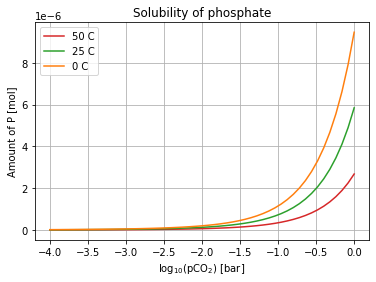

In [33]:
plt.figure()
plt.title("Solubility of phosphate")
plt.plot(co2ppressures, data50[:, 2], label=f'{temperatures[2]} C', color='C3')
plt.plot(co2ppressures, data25[:, 2], label=f'{temperatures[1]} C', color='C2')
plt.plot(co2ppressures, data0[:, 2], label=f'{temperatures[0]} C', color='C1')
plt.legend(loc="best")
plt.xlabel(r'$\log_{10}(\rm{pCO}_2)$ [bar]')
plt.ylabel('Amount of P [mol]')
plt.grid()

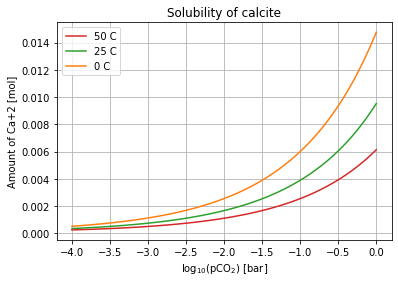

In [34]:
plt.figure()
plt.title("Solubility of calcite")
plt.plot(co2ppressures, data50[:, 3], label=f'{temperatures[2]} C', color='C3')
plt.plot(co2ppressures, data25[:, 3], label=f'{temperatures[1]} C', color='C2')
plt.plot(co2ppressures, data0[:, 3], label=f'{temperatures[0]} C', color='C1')
plt.legend(loc="best")
plt.xlabel(r'$\log_{10}(\rm{pCO}_2)$ [bar]')
plt.ylabel('Amount of Ca+2 [mol]')
plt.grid()

Alternatively, we can plot the two-dimensional dependence of the phosphate solubility and pH on the range of
partial CO<sub>2</sub> pressures and temperatures. The code does these calculations:

In [35]:
num_temperatures = 51
num_log10pCO2s = 101
temperatures =  np.linspace(0.0, 50.0, num=num_temperatures)
co2ppressures = np.linspace(-4.0, 0.0, num=num_log10pCO2s)

data_size = 2
data_pH = np.zeros((num_temperatures, num_log10pCO2s))
data_P = np.zeros((num_temperatures, num_log10pCO2s))

for i in range(0, num_temperatures):
    for j in range(0, num_log10pCO2s):
        result = equilibrate(co2ppressures[j], temperatures[i])
        data_pH[i, j] = result[0]
        data_P[i, j] = result[1]

From the plots below, we see that relatively low CO<sub>2</sub> pressures log<sub>10</sub>(pCO<sub>2</sub>) = −3.5
(corresponding to the on present-day Earth) limit phosphate to ≤1 μM, which is consistent with phosphate concentrations
found in a majority of present-day rivers and surface waters. However, in CO<sub>2</sub>-rich atmospheres relevant to
the early Earth (corresponding to log<sub>10</sub>(pCO<sub>2</sub>) = 0.01 to 1 bar), resulting phosphate concentrations
are one or two orders of magnitude higher. The latter implies a much higher phosphate weathering flux on the early
Earth from streams into lakes.

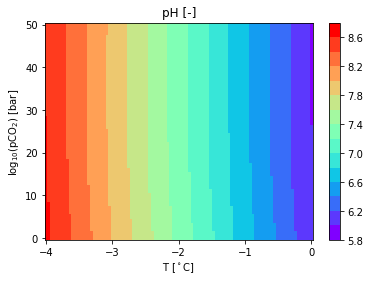

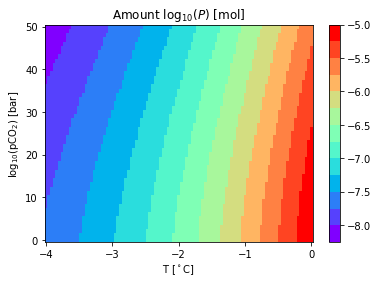

In [36]:
import matplotlib as ml
import matplotlib.pyplot as plt
from matplotlib.colors import BoundaryNorm
from matplotlib.ticker import MaxNLocator

levels = MaxNLocator(nbins=15).tick_values(data_pH.min(), data_pH.max())
cmap = ml.cm.get_cmap('rainbow')
norm = BoundaryNorm(levels, ncolors=cmap.N, clip=True)

fig, ax = plt.subplots(1, 1)
im = plt.pcolormesh(co2ppressures, temperatures, data_pH, cmap=cmap, norm=norm, shading='auto')
fig.colorbar(im, ax=ax)
ax.set_title('pH [-]')
ax.set_xlabel(r'T [$^\circ$C]')
ax.set_ylabel(r'$\log_{10}(\sf{pCO}_2)$ [bar]')

levels = MaxNLocator(nbins=15).tick_values(np.log10(data_P).min(), np.log10(data_P).max())
cmap = ml.cm.get_cmap('rainbow')
norm = BoundaryNorm(levels, ncolors=cmap.N, clip=True)

fig, ax = plt.subplots(1, 1)
im = plt.pcolormesh(co2ppressures, temperatures, np.log10(data_P), cmap=cmap, norm=norm,  shading='auto')
fig.colorbar(im, ax=ax)
ax.set_title(r'Amount $\log_{10}(P)$ [mol]')
ax.set_xlabel(r'T [$^\circ$C]')
ax.set_ylabel(r'$\log_{10}(\sf{pCO}_2)$ [bar]');

## Solubility of phosphate in the vivianite- and siderite-rich lakes

A potential sink for soluble phosphate on the early Earth is reduced soluble iron (Fe<sup>+2</sup>), which precipitates
with phosphate as the low-solubility mineral vivianite (Fe<sub>3</sub>(PO<sub>4</sub>)<sub>2</sub> · 8H<sub>2</sub>O).
However, at the same time, Fe<sup>+2</sup> also precipitates
as siderite (FeCO<sub>3</sub>) in carbonate-rich brines, which limits Fe<sup>+2</sup> to low levels and increases the solubility
of phosphate from vivianite. Below, we model this behavior and compare the results to the system with apatities.

In [37]:
solution = AqueousPhase(speciate("H O C Na Cl Ca P Fe"))
solution.setActivityModel(chain(
    ActivityModelHKF(),
    ActivityModelDrummond("CO2")
))

minerals = MineralPhase("Siderite Vivianite")

system = ChemicalSystem(db, solution, minerals)

aprops = AqueousProps(system)
props = ChemicalProps(system)

specs = EquilibriumSpecs(system)
specs.temperature()
specs.pressure()
specs.fugacity("CO2")

conditions = EquilibriumConditions(specs)

solver = EquilibriumSolver(specs)
opts = EquilibriumOptions()
opts.epsilon = 1e-13
solver.setOptions(opts)

def equilibrate_with_siderite(ppCO2, T):

    conditions.temperature(T, "celsius")
    conditions.pressure(1.0, "atm")
    conditions.fugacity("CO2", 10 ** (ppCO2), 'atm')

    state = ChemicalState(system)
    state.set("H2O"      ,   1.0, "kg")
    state.set("Siderite" ,  10.0, "mol")
    state.set("Vivianite",  10.0, "mol")
    state.set("CO2"      , 100.0, "mol")

    solver.solve(state, conditions)

    aprops.update(state)
    props.update(state)

    pH = aprops.pH()[0]
    molP = props.elementAmountInPhase("P", "AqueousPhase")[0]
    molFe = props.elementAmountInPhase("Fe", "AqueousPhase")[0]

    return pH, molP, molFe

num_temperatures = 3
num_log10pCO2s = 51
temperatures = np.array([0, 25, 50])
co2ppressures = np.linspace(-4.0, 0.0, num=num_log10pCO2s)

data_size = 3
data50 = np.zeros((num_log10pCO2s, data_size + 1))
data25 = np.zeros((num_log10pCO2s, data_size + 1))
data0 = np.zeros((num_log10pCO2s, data_size + 1))

for i in range(0, num_log10pCO2s):

    result = equilibrate_with_siderite(co2ppressures[i], temperatures[2])
    data50[i, 0], data50[i, 1], data50[i, 2], data50[i, 3] = co2ppressures[i], result[0], result[1], result[2]

    result = equilibrate_with_siderite(co2ppressures[i], temperatures[1])
    data25[i, 0], data25[i, 1], data25[i, 2], data25[i, 3] = co2ppressures[i], result[0], result[1], result[2]

    result = equilibrate_with_siderite(co2ppressures[i], temperatures[0])
    data0[i, 0], data0[i, 1], data0[i, 2], data0[i, 3]  = co2ppressures[i], result[0], result[1], result[2]

Apatites are more soluble at lower pH and weather more rapidly in CO<sub>2</sub>-acidified stream and rainwater,
resulting in potentially high phosphate fluxes to carbonate-rich lakes on the early Earth.

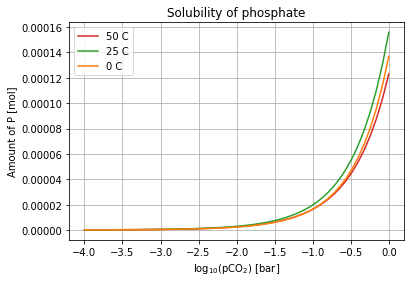

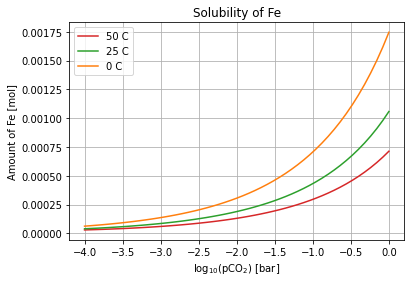

In [38]:
plt.figure()
plt.title("Solubility of phosphate")
plt.plot(co2ppressures, data50[:, 2], label=f'{temperatures[2]} C', color='C3')
plt.plot(co2ppressures, data25[:, 2], label=f'{temperatures[1]} C', color='C2')
plt.plot(co2ppressures, data0[:, 2], label=f'{temperatures[0]} C', color='C1')
plt.legend(loc="best")
plt.xlabel(r'$\log_{10}(\sf{pCO}_2)$ [bar]')
plt.ylabel('Amount of P [mol]')
plt.grid()

plt.figure()
plt.title("Solubility of Fe")
plt.plot(co2ppressures, data50[:, 3], label=f'{temperatures[2]} C', color='C3')
plt.plot(co2ppressures, data25[:, 3], label=f'{temperatures[1]} C', color='C2')
plt.plot(co2ppressures, data0[:, 3], label=f'{temperatures[0]} C', color='C1')
plt.legend(loc="best")
plt.xlabel(r'$\log_{10}(\sf{pCO}_2)$ [bar]')
plt.ylabel('Amount of Fe [mol]')
plt.grid()

Due to the lower solubility of siderite (in comparison to calcite) as well as the fact that its nucleation and
growth is not inhibited by phosphate, Fe<sup>+2</sup> concentrations in anoxic, phosphate- and carbonate-rich brines is expected
to be lower than Ca<sup>+2</sup>. We see it from the plot of the solubility of iron.
This suggests that Ca<sup>+2</sup>, not Fe<sup>+2</sup>, would have controlled phosphate concentrations in carbonate-rich
lakes on the early Earth.